<a href="https://colab.research.google.com/github/OANInternational/aguapp/blob/master/create_pump_map.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Proyecto para crear mapas y estudios a partir de las bases de datos de bombas

# INSTALS, JUST RUN ONCE

In [170]:
!apt-get install libgeos-3.5.0
!apt-get install libgeos-dev
!pip install https://github.com/matplotlib/basemap/archive/master.zip
!pip install pyproj==1.9.6

Reading package lists... Done
Building dependency tree       
Reading state information... Done
E: Unable to locate package libgeos-3.5.0
E: Couldn't find any package by glob 'libgeos-3.5.0'
E: Couldn't find any package by regex 'libgeos-3.5.0'
Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-410
Use 'apt autoremove' to remove it.
Suggested packages:
  libgdal-doc
The following NEW packages will be installed:
  libgeos-dev
0 upgraded, 1 newly installed, 0 to remove and 16 not upgraded.
Need to get 73.1 kB of archives.
After this operation, 486 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libgeos-dev amd64 3.6.2-1build2 [73.1 kB]
Fetched 73.1 kB in 0s (986 kB/s)
Selecting previously unselected package libgeos-dev.
(Reading database ... 130942 files and directories currently installed.)
Pre

     |████████████████████████████████| 2.8MB 6.5MB/s 
  Stored in directory: /root/.cache/pip/wheels/02/cd/b1/a2d6430f74c7a778a43d62f78bec109ca69c732dc9b929142a
Successfully built pyproj
  Found existing installation: pyproj 2.2.1
    Uninstalling pyproj-2.2.1:
      Successfully uninstalled pyproj-2.2.1


# DIRECTORIO

utilizar google como directorio de trabajo


In [0]:
%cd

/root


In [0]:
%cd
%cd ..
%cd content

/root
/
/content


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
!ls

drive  sample_data


In [1]:
%cd drive/'Shared drives'/'Comité de Infraestructuras, Energía y Agua'/'Proyectos'/'Red de Reparadores de Bombas Manuales'/'Prototipo Automatización'/'Mapas'

/content/drive/Shared drives/Comité de Infraestructuras, Energía y Agua/Proyectos/Red de Reparadores de Bombas Manuales/Prototipo Automatización/Mapas


In [0]:
import yaml
spreadsheet_ids = yaml.load( open("parameters.yaml", "r" ))
#bombas de 2018, ultima version
ID1=str(spreadsheet_ids['ID1'])
#bombas de 2016, ultima version
ID2=str(spreadsheet_ids['ID2'])
#bombas de 2009, ultima version
ID3=str(spreadsheet_ids['ID3'])
#bombas final, datos de 2016 y 2009
ID4=str(spreadsheet_ids['ID4'])

# GSHEET & GDRIVE AUTHETICATION

In [0]:
from google.colab import auth
auth.authenticate_user()

In [0]:
from googleapiclient.discovery import build
sheet_service = build('sheets', 'v4')

# IMPORTS

In [0]:
import plotly
import plotly.plotly as py
import numpy as np
import re


import matplotlib.pyplot as plt

import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.font_manager as font_manager
import matplotlib.dates
import seaborn as sns

import folium
import matplotlib.patches as mpatches

from mpl_toolkits.basemap import Basemap
from matplotlib import colors as mcolors

from scipy import stats



Colors to use for plots

In [0]:
colors = dict(mcolors.BASE_COLORS, **mcolors.CSS4_COLORS)

# FUNCTIONS

In [0]:
'''
Function to change latitude/longitude data from degrees,minutes and seconds into decimals
'''
def decimals_lat_lon(x,lat):
  coord=None
  if x[lat]:
    if len(x[lat])>2:
      if len(re.split('[°\'"]', x[lat])) == 4 :
        
        #gets all the parts of the coordinates into different elements of a vector
        deg, minutes, seconds, direction =  re.split('[°\'"]', x[lat])
        
        #had to put replace commas because of data of 2009
        coord=(float(deg) + float(minutes.replace(",","."))/60 + float(seconds.replace(",","."))/(60*60)) * (-1 if direction in ['W', 'S'] else 1)
      elif len(re.split('[°\'"]', x[lat])) > 0:
        coord=x[lat]
        print(coord)
  else:
    coord=None
    print(coord)
  return coord

In [0]:
#function to draw a map with the dataframe 
def drawmap(df,title,zoom,savefig):
  data=df
  map_colors = {}
  l_arron = data['Arrondissement'].unique().tolist()
  [map_colors.update({arron: colors[list(colors.keys())[i*3+8]]}) for i,arron in enumerate(l_arron) ]
  lat_begin=data['Latitude_decimals'].quantile(0.5)

  lat_min=data['Latitude_decimals'].min()
  lat_max=data['Latitude_decimals'].max()

  lon_min=data['Longitude_decimals'].min()
  lon_max=data['Longitude_decimals'].max()

  lon_begin=data['Longitude_decimals'].quantile(0.5)
  lats=np.array(data['Latitude_decimals'])
  lons=np.array(data['Longitude_decimals'])
  zoom_scale = 0

  # Setup the bounding box for the zoom and bounds of the map
  bbox = [np.min(lats)-zoom_scale,np.max(lats)+zoom_scale,\
          np.min(lons)-zoom_scale,np.max(lons)+zoom_scale]

  plt.figure(figsize=(25,12))
  # Define the projection, scale, the corners of the map, and the resolution.
  m = Basemap(projection='merc',llcrnrlat=lat_min-zoom,urcrnrlat=lat_max+zoom,\
              llcrnrlon=lon_min-zoom,urcrnrlon=lon_max+zoom,lat_ts=10,resolution='i')

  # Draw coastlines and fill continents and water with color
  m.drawcoastlines()
  m.fillcontinents(color='grey',lake_color='dodgerblue')

  # draw parallels, meridians, and color boundaries
  m.drawparallels(np.arange(bbox[0],bbox[1],(bbox[1]-bbox[0])/5),labels=[1,0,0,0])
  m.drawmeridians(np.arange(bbox[2],bbox[3],(bbox[3]-bbox[2])/5),labels=[0,0,0,1],rotation=45)
  m.drawmapboundary(fill_color='dodgerblue')
  m.readshapefile('gadm36_BEN_shp/gadm36_BEN_2','NAME_2')
  # build and plot coordinates onto map
  for arron in l_arron:
    data_arron=data[data['Arrondissement']==arron]
    lats=np.array(data_arron['Latitude_decimals'])
    lons=np.array(data_arron['Longitude_decimals'])
    x,y = m(lons,lats)
    m.plot(x,y,'.',c=map_colors[arron],markersize=5,label=arron+'_'+str(len(data_arron)))

  plt.legend()

  plt.title(title +'\n total points:'+str(len(data)))
  if savefig:
    plt.savefig(title+'.png', format='png', dpi=500)
  plt.show()

In [0]:
#function to bubble plot into map with a dataframe and give a bubble size depending on the nº of points

def drawbubblemap(df,title,zoom,savefig):
  data=df

  df_count=data[['Arrondissement','Village']].groupby('Arrondissement',axis=0).count()

  map_colors = {}
  l_arron = data['Arrondissement'].unique().tolist()
  [map_colors.update({arron: colors[list(colors.keys())[i*3+8]]}) for i,arron in enumerate(l_arron) ]

  lat_begin=data['Latitude_decimals'].quantile(0.5)

  lat_min=data['Latitude_decimals'].min()
  lat_max=data['Latitude_decimals'].max()

  lon_min=data['Longitude_decimals'].min()
  lon_max=data['Longitude_decimals'].max()

  lon_begin=data['Longitude_decimals'].quantile(0.5)
  lats=np.array(data['Latitude_decimals'])
  lons=np.array(data['Longitude_decimals'])
  zoom_scale = 0

  # Setup the bounding box for the zoom and bounds of the map
  bbox = [np.min(lats)-zoom_scale,np.max(lats)+zoom_scale,\
          np.min(lons)-zoom_scale,np.max(lons)+zoom_scale]

  plt.figure(figsize=(25,12))
  # Define the projection, scale, the corners of the map, and the resolution.
  m = Basemap(projection='merc',llcrnrlat=lat_min-zoom,urcrnrlat=lat_max+zoom,\
              llcrnrlon=lon_min-zoom,urcrnrlon=lon_max+zoom,lat_ts=10,resolution='i')

  # Draw coastlines and fill continents and water with color
  m.drawcoastlines()
  m.fillcontinents(color='grey',lake_color='dodgerblue')

  # draw parallels, meridians, and color boundaries
  m.drawparallels(np.arange(bbox[0],bbox[1],(bbox[1]-bbox[0])/5),labels=[1,0,0,0])
  m.drawmeridians(np.arange(bbox[2],bbox[3],(bbox[3]-bbox[2])/5),labels=[0,0,0,1],rotation=45)
  m.drawmapboundary(fill_color='dodgerblue')
  m.readshapefile('gadm36_BEN_shp/gadm36_BEN_2','NAME_2')
  handlers =[]
  # build and plot coordinates onto map
  for arron in l_arron:
    data_arron=data[data['Arrondissement']==arron]
    lats=np.array(data_arron['Latitude_decimals'].quantile(0.5))
    lons=np.array(data_arron['Longitude_decimals'].quantile(0.5))
    size=df_count.loc[arron,'Village']
    x,y = m(lons,lats)
    m.plot(x,y,'.',c=map_colors[arron],markersize=size*2)
    handlers.append(mpatches.Patch(color=map_colors[arron], label=arron))

  plt.legend(handles=handlers)
  plt.title(title)
  if savefig:
    plt.savefig(title+'.png', format='png', dpi=500)
  plt.show()

# 2019 STUDY

In [0]:
SPREADSHEET_ID = ID1
RANGE_NAME = 'Sheet1'

gsheet = sheet_service.spreadsheets().values().get(spreadsheetId=SPREADSHEET_ID, range=RANGE_NAME).execute()

df_2019 = pd.DataFrame(gsheet.get('values', [])[1:],columns= gsheet.get('values', [])[0:1][0])

In [0]:
df_2019.head()

,Arrondissement,Village,Localite,Nom_Local,Longitude,Latitude,xCoord,yCoord,rqtListe_Pompe.Modele_Pompe
0,BIRO,BIRO,Biro,BIRO 2,"02°56'52.0""E","09°54'00.0""N",2.947778,9.9,VERGNET
1,BIRO,BIRO,Sarawondo,SARAWONDO,"02°58'29.2""E","09°54'13.2""N",2.974778,9.903666,VERGNET
2,BIRO,BIRO,Nallou,NANLOU,"02°54'30.2""E","09°56'00.0""N",2.908389,9.933333,VERGNET
3,BIRO,BIRO,Biro,BIRO CENTRE,"02°56'26.3""E","09°54'10.0""N",2.940639,9.902778,None
4,BIRO,BIRO,Biro,BIRO CENTRE,"02°56'47.9""E","09°54'10.9""N",2.946639,9.903028,AFRIDEV


In [0]:
df_2019.groupby('Arrondissement',axis=0).count()

,Village,Localite,Nom_Local,Longitude,Latitude,xCoord,yCoord,rqtListe_Pompe.Modele_Pompe
Arrondissement,,,,,,,,
BIRO,30,30,30,30,30,30,30,25
GNONKOURAKALI,36,36,36,36,36,36,36,33
NIKKI,132,132,132,132,132,132,132,109
OUENOU,56,56,56,56,56,56,56,44
SEREKALE,54,54,54,53,53,53,53,43
SUYA,16,16,16,16,16,16,16,12
TASSO,41,41,41,41,41,41,41,36


In [12]:
df_2019['Latitude_decimals']=df_2019.apply(lambda x: decimals_lat_lon(x,'Latitude'),axis=1)

None
None


In [13]:
df_2019['Longitude_decimals']=df_2019.apply(lambda x: decimals_lat_lon(x,'Longitude'),axis=1)

None
None


In [0]:
df_2019=df_2019.dropna(subset=['Longitude_decimals', 'Latitude_decimals'])

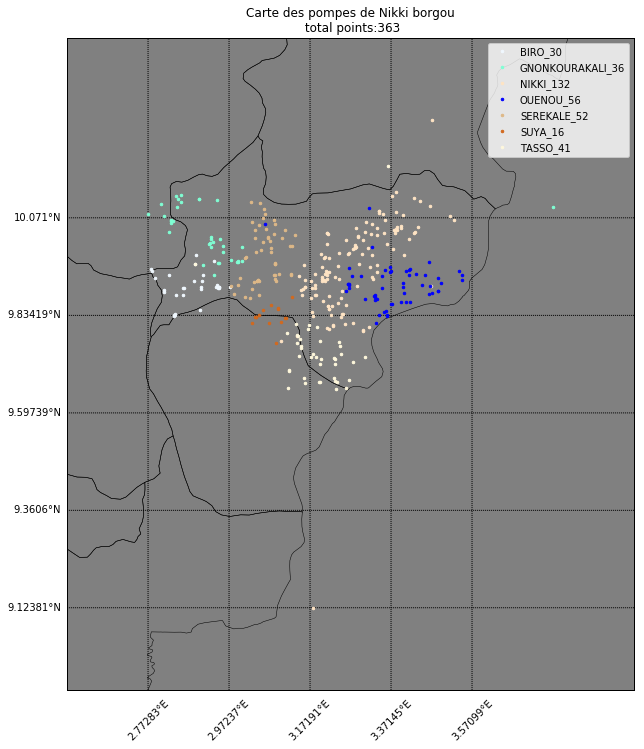

In [15]:
title="Carte des pompes de Nikki borgou"
#zoom=4
zoom=0.2
drawmap(df_2019,title,zoom,False)

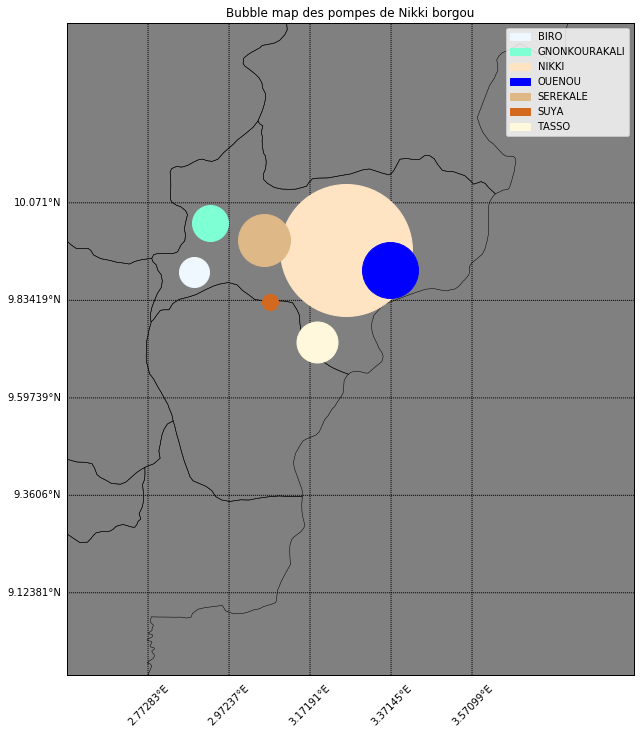

In [16]:
title="Bubble map des pompes de Nikki borgou"
#zoom=4
zoom=0.2

drawbubblemap(df_2019,title,zoom,False)

<BarContainer object of 15 artists>

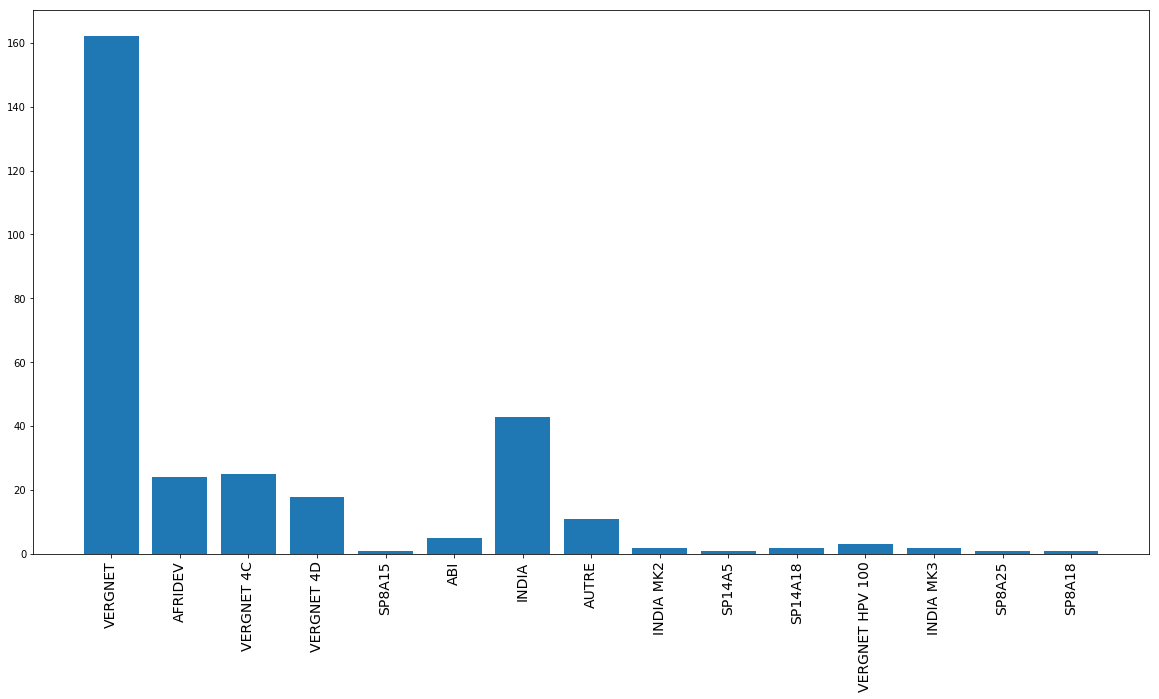

In [18]:
plt.rcParams['figure.figsize'] = 20,10
x=list(df_2019['rqtListe_Pompe.Modele_Pompe'].dropna().unique())
y=[df_2019[df_2019['rqtListe_Pompe.Modele_Pompe']==model]['rqtListe_Pompe.Modele_Pompe'].count() for model in x]

plt.xticks(fontsize=14,rotation=90)
plt.bar(x,y)

LEER EL SHAPEFILE DESCARAGO DE:

https://gadm.org/download_country_v3.html ->benin

In [0]:
import shapefile as shp

In [0]:
shp_path = 'gadm36_BEN_shp/gadm36_BEN_2.shp'
sf = shp.Reader(shp_path)

In [0]:
def read_shapefile(sf):
    """
    Read a shapefile into a Pandas dataframe with a 'coords' 
    column holding the geometry information. This uses the pyshp
    package
    """
    fields = [x[0] for x in sf.fields][1:]
    records = sf.records()
    shps = [s.points for s in sf.shapes()]
    df = pd.DataFrame(columns=fields, data=records)
    df = df.assign(coords=shps)
    return df

In [0]:
df = read_shapefile(sf)
df.shape

(76, 14)

In [0]:
df

,GID_0,NAME_0,GID_1,NAME_1,NL_NAME_1,GID_2,NAME_2,VARNAME_2,NL_NAME_2,TYPE_2,ENGTYPE_2,CC_2,HASC_2,coords
0,BEN,Benin,BEN.1_1,Alibori,,BEN.1.1_1,Banikoara,,,Commune,Commune,,BJ.AL.BA,"[(2.8467729091645424, 11.42146110534668), (2.8..."
1,BEN,Benin,BEN.1_1,Alibori,,BEN.1.2_1,Gogounou,,,Commune,Commune,,BJ.AL.GO,"[(2.2658329010010902, 10.54574203491211), (2.2..."
2,BEN,Benin,BEN.1_1,Alibori,,BEN.1.3_1,Kandi,,,Commune,Commune,,BJ.AL.KN,"[(3.273935079574642, 11.306771278381404), (3.2..."
3,BEN,Benin,BEN.1_1,Alibori,,BEN.1.4_1,Karimama,,,Commune,Commune,,BJ.AL.KR,"[(3.2918179035187904, 11.928750991821289), (3...."
4,BEN,Benin,BEN.1_1,Alibori,,BEN.1.5_1,Malanville,,,Commune,Commune,,BJ.AL.MA,"[(3.5912120342255776, 11.673298835754451), (3...."
5,BEN,Benin,BEN.1_1,Alibori,,BEN.1.6_1,Segbana,,,Commune,Commune,,BJ.AL.SE,"[(3.7127580642700764, 11.127946853637809), (3...."
6,BEN,Benin,BEN.2_1,Atakora,,BEN.2.1_1,Boukoumbé,Boukombé,,Commune,Commune,,BJ.AK.BO,"[(1.3887850046158974, 10.039131164550838), (1...."
7,BEN,Benin,BEN.2_1,Atakora,,BEN.2.2_1,Cobly,Cobli|Cobli,,Commune,Commune,,BJ.AK.CB,"[(0.897539973259029, 10.29423904418951), (0.88..."
8,BEN,Benin,BEN.2_1,Atakora,,BEN.2.3_1,Kérou,,,Commune,Commune,,BJ.AK.KE,"[(2.2658329010010902, 10.54574203491211), (2.2..."
9,BEN,Benin,BEN.2_1,Atakora,,BEN.2.4_1,Kouandé,,,Commune,Commune,,BJ.AK.KO,"[(1.3887850046158974, 10.039131164550838), (1...."


# 2016 STUDY

In [0]:
SPREADSHEET_ID = ID2
RANGE_NAME = 'Sheet1'

gsheet = sheet_service.spreadsheets().values().get(spreadsheetId=SPREADSHEET_ID, range=RANGE_NAME).execute()

df_2016 = pd.DataFrame(gsheet.get('values', [])[1:],columns= gsheet.get('values', [])[0:1][0])

In [20]:
df_2016.head()

,N°,Arrondissement,Village,Localité,Hameau,Etat de l'ouvrage,Redevance,Année de réalisation,Marque
0,284,BIRO,Biro,Nallou,Nallou Banikparou,Fonctionnel,Jamais,2004,Vergnet
1,285,BIRO,Biro,Goutto,Goutto,Fonctionnel,Jamais,2011,Vergnet
2,286,BIRO,Biro,Nanlou,Nanlou,Fonctionnel,Jamais,,Vergnet
3,287,BIRO,Biro,Sarawodo,Sarawodo,Fonctionnel,Parfait,Entente 95,Vergnet
4,288,BIRO,Biro,Biro,Biro 1,Fonctionnel,Parfait,PPEA 2010,Vergnet


In [21]:
df_2016['Année de réalisation'].unique()

array(['2004', '2011', '', 'Entente 95', 'PPEA 2010', 'Puits Réhabilité',
       '2002', 'Chinois 2013', 'Helvetas 2013', 'Puits Réhabilité 2014',
       '2007', 'PADEAR 2003', '2003', '2005', '1995', 'PPEA 2012',
       '2009 DANIDA', 'DANIDA 2006', 'FS 2011', '2012 HELVETAS',
       'PADSEA 2003', None, '2012', '2 becs ENTENTE 1995', 'UEMOA 2008',
       '2006', 'ACCES 2013', '2003 PADEAR', 'Programme Chinois 2013',
       'Réhabilité par ACCES', 'Réhabilité par Helvetas', '2009 Danida',
       '2007 Danida', 'Entente 1996', '2008 UEMOA', 'PSDCC  2016',
       'Pagirel 2009', 'PPEA 2011', '2005 Danida', 'Entente 95 HPV',
       'Padsea 2007', 'Entente 3 1995 P-B132', 'B 2599 2002',
       'UEMOA 2015', 'Réha Helvetas 2013', 'PAFILAV 2016', '2013',
       'ACCES 2016', '2009', 'FS 2012', 'Danida 2001',
       'Réha Helvetas 2009', 'GAIN 2009', 'DANIDA 2002', 'PPEA 2013',
       'GAIN 2008', 'GAIN 2011 Dassari', 'CE1 1990', 'CE 1 1995',
       'HPV1 2012', 'HPV 6', 'ACCES 2014', 'Helve

In [0]:
def getyear(x):
  year=None
  if x['Année de réalisation']:
    for s in x['Année de réalisation'].split():
      if s.isdigit():
         year=int(s)
    if year==None:
      return year
    elif year >2019:
      #print(year)
      year=2010
      return year
    elif year > 100:
      return int(year)
    elif year >70:
      year=int('19'+str(year))
      return int(year)
    else:
      year=None
    
  return year


In [0]:
df_2016['Annes']=df_2016.apply(lambda x: getyear(x)
              ,axis=1)

In [25]:
df_2016['Marque'].unique()

array(['Vergnet', 'India', None, 'PEA', 'V ergnet 2011', 'AFRIDEV',
       'Vergnet (B2599)', 'Abandonné', 'Vergnet ???', 'vergnet'],
      dtype=object)

In [0]:
def marques(x):
  marque='NA'
  
  if x['Marque']:
    if bool(re.search('ergnet',x['Marque'])):
      marque='Vergnet'
    elif bool(re.search('ndia',x['Marque'])):
      marque='India'
    elif bool(re.search('AFRI',x['Marque'])):
      marque='Afridev'
  return marque

In [0]:
df_2016['type']=df_2016.apply(lambda x: marques(x),axis=1)

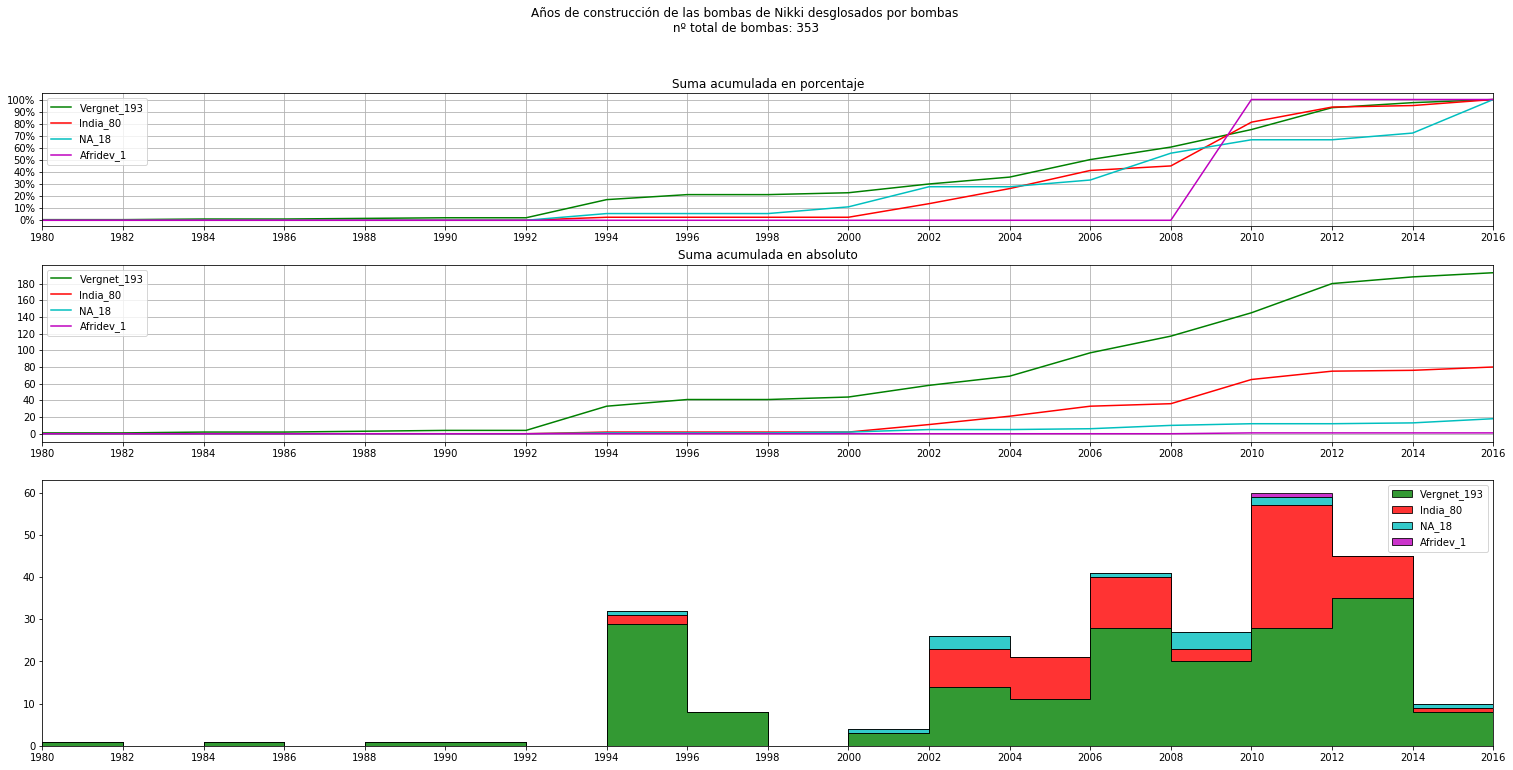

In [28]:
n=40
bins=np.arange(1980,2017+int(100/n),int(100/n))

plt.rcParams['figure.figsize']=26,12
f, (ax_plot,ax_plot2,ax_hist) = plt.subplots(3, gridspec_kw={'height_ratios': [3, 4, 6]})

subplots = [ax_plot,ax_plot2,ax_hist]
l_marques = df_2016['type'].unique().tolist()

l_colors=list(colors.keys())[1:5]

kwargs = dict(histtype='stepfilled', alpha=0.8, bins=bins,edgecolor='black')

datas = []

labels= []

for i,typ in enumerate(l_marques):

  data = df_2016[df_2016['type']==typ]['Annes'].dropna()
  datas.append(data)
  label=typ+'_'+str(len(data))
  labels.append(label)
  #If want to plot one histogram for each iteration, "discomment" the next line
  #ax_hist.hist(data, color=colors[l_colors[i]],label=label, **kwargs)


  values, base = np.histogram(data, bins=bins)
      #evaluate the cumulative
  cumulative = np.cumsum(values)

  cumulative2 = [val/max(cumulative) for val in cumulative]

  ax_plot.plot(base[:-1], cumulative2,color=colors[l_colors[i]],label=label)
  ax_plot2.plot(base[:-1], cumulative,color=colors[l_colors[i]],label=label)
  
ax_hist.hist(datas, stacked=True, color = l_colors, label=labels,**kwargs)

ax_plot.grid()
ax_plot2.grid()

vals = ax_plot.get_yticks()

ax_plot.set_yticks(np.arange(0,1.1,0.1))
ax_plot2.set_yticks(np.arange(0,200,20))

vals = ax_plot.get_yticks()

ax_plot.set_yticklabels(['{:,.0%}'.format(x) for x in vals])

xticks=np.arange(1980,2017,2)
for subpl in subplots:
  subpl.set_xticks(xticks)
  subpl.set_xlim([1980,2016])

ax_plot.set_title('Suma acumulada en porcentaje')
ax_plot2.set_title('Suma acumulada en absoluto')
f.suptitle('Años de construcción de las bombas de Nikki desglosados por bombas'+
           '\n nº total de bombas: '+str(len(df_2016))
          )

ax_plot.legend()
ax_plot2.legend()


# sort both labels and handles by labels
#labels, handles = zip(*sorted(zip(labels, handles), key=lambda t: t[0],reverse=True))
handles, labels = ax_hist.get_legend_handles_labels()
labels=[labels[3],labels[2],labels[1],labels[0]]
handles =  [handles[3],handles[2],handles[1],handles[0]]
                     
ax_hist.legend(handles, labels)

plt.show()

In [0]:
SPREADSHEET_ID = ID3
RANGE_NAME = 'Sheet1'

gsheet = sheet_service.spreadsheets().values().get(spreadsheetId=SPREADSHEET_ID, range=RANGE_NAME).execute()

df_2009 = pd.DataFrame(gsheet.get('values', [])[1:],columns= gsheet.get('values', [])[0:1][0])

In [30]:
df_2009.head()

,Arrondissement,Village,Localité,Population,Type d'ouvrage,Etat,Longitude,Latitude,Domaine d'installation
0,BIRO,Biro,Bah Boré,150,/,/,/,/,/
1,BIRO,Biro,Biro,5000,FPM,Fonctionnel,"02°56'48,5""E","09°54'10,7""N",Marché
2,BIRO,Biro,Biro,5000,FPM,Fonctionnel,"02°56'52,0""E","09°54'18,6""N",Domaine public
3,BIRO,Biro,Biro,5000,FPM,Fonctionnel,"02°57'03,7""E","09°54'11,4""N",Domaine public
4,BIRO,Biro,Biro,5000,PM,Fonctionnel,"02°56'51,1""E","09°54'08,5""N",Marché


In [31]:
df_2019.head()

,Arrondissement,Village,Localite,Nom_Local,Longitude,Latitude,xCoord,yCoord,rqtListe_Pompe.Modele_Pompe,Latitude_decimals,Longitude_decimals
0,BIRO,BIRO,Biro,BIRO 2,"02°56'52.0""E","09°54'00.0""N",2.947778,9.9,VERGNET,9.900000,2.947778
1,BIRO,BIRO,Sarawondo,SARAWONDO,"02°58'29.2""E","09°54'13.2""N",2.974778,9.903666,VERGNET,9.903667,2.974778
2,BIRO,BIRO,Nallou,NANLOU,"02°54'30.2""E","09°56'00.0""N",2.908389,9.933333,VERGNET,9.933333,2.908389
3,BIRO,BIRO,Biro,BIRO CENTRE,"02°56'26.3""E","09°54'10.0""N",2.940639,9.902778,None,9.902778,2.940639
4,BIRO,BIRO,Biro,BIRO CENTRE,"02°56'47.9""E","09°54'10.9""N",2.946639,9.903028,AFRIDEV,9.903028,2.946639


In [32]:
df_2009['Latitude_decimals']=df_2009.apply(lambda x: decimals_lat_lon(x,'Latitude'),axis=1)

None
None
None
None
None


In [33]:
df_2009['Longitude_decimals']=df_2009.apply(lambda x: decimals_lat_lon(x,'Longitude'),axis=1)

None
None
None
None
None


In [0]:
df_2009_points=df_2009.dropna(subset=['Longitude_decimals', 'Latitude_decimals'])

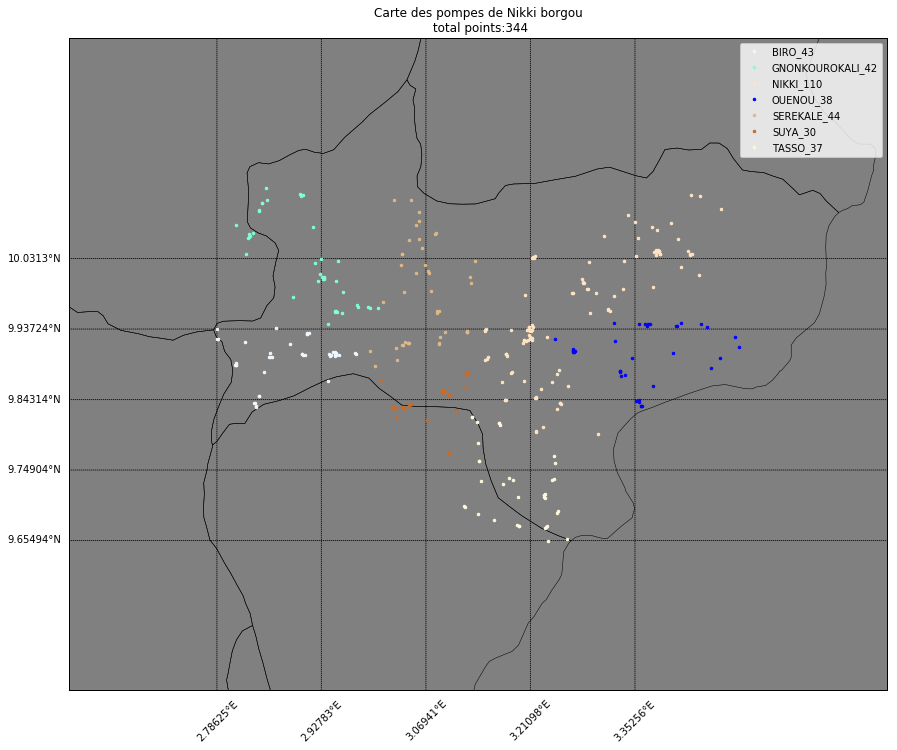

In [35]:
title="Carte des pompes de Nikki borgou"
#zoom=4
zoom=0.2
drawmap(df_2009_points,title,zoom,False)

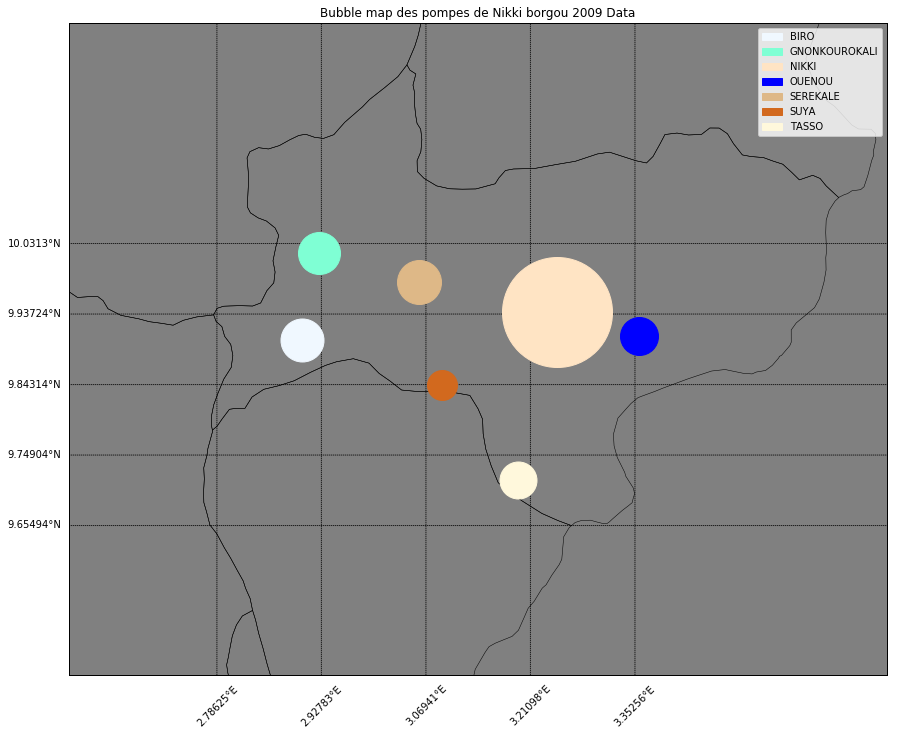

In [37]:
title="Bubble map des pompes de Nikki borgou 2009 Data"
#zoom=4
zoom=0.2

drawbubblemap(df_2009_points,title,zoom,True)

## Population Study

In [0]:
df_2009['Pop']=[int(pop) if pop else None for pop in df_2009['Population'] ]

In [67]:
df_2009.columns

Index(['Arrondissement', 'Village', 'Localité', 'Population', 'Type d'ouvrage',
       'Etat', 'Longitude', 'Latitude', 'Domaine d'installation',
       'Latitude_decimals', 'Longitude_decimals', 'Pop'],
      dtype='object')

In [0]:
dfex=df_2009.groupby('Localité')

In [0]:
df_localite=df_2009.groupby('Localité')

df_pop = pd.DataFrame(index=df_localite.size().index.tolist(), columns=['Pop','haspump'])
df_pop['Pop'] = list(df_localite['Pop'].mean())
df_pop['haspump'] = [bool(re.search('FPM',ouvre)) for ouvre in list(dfex["Type d'ouvrage"].sum())]



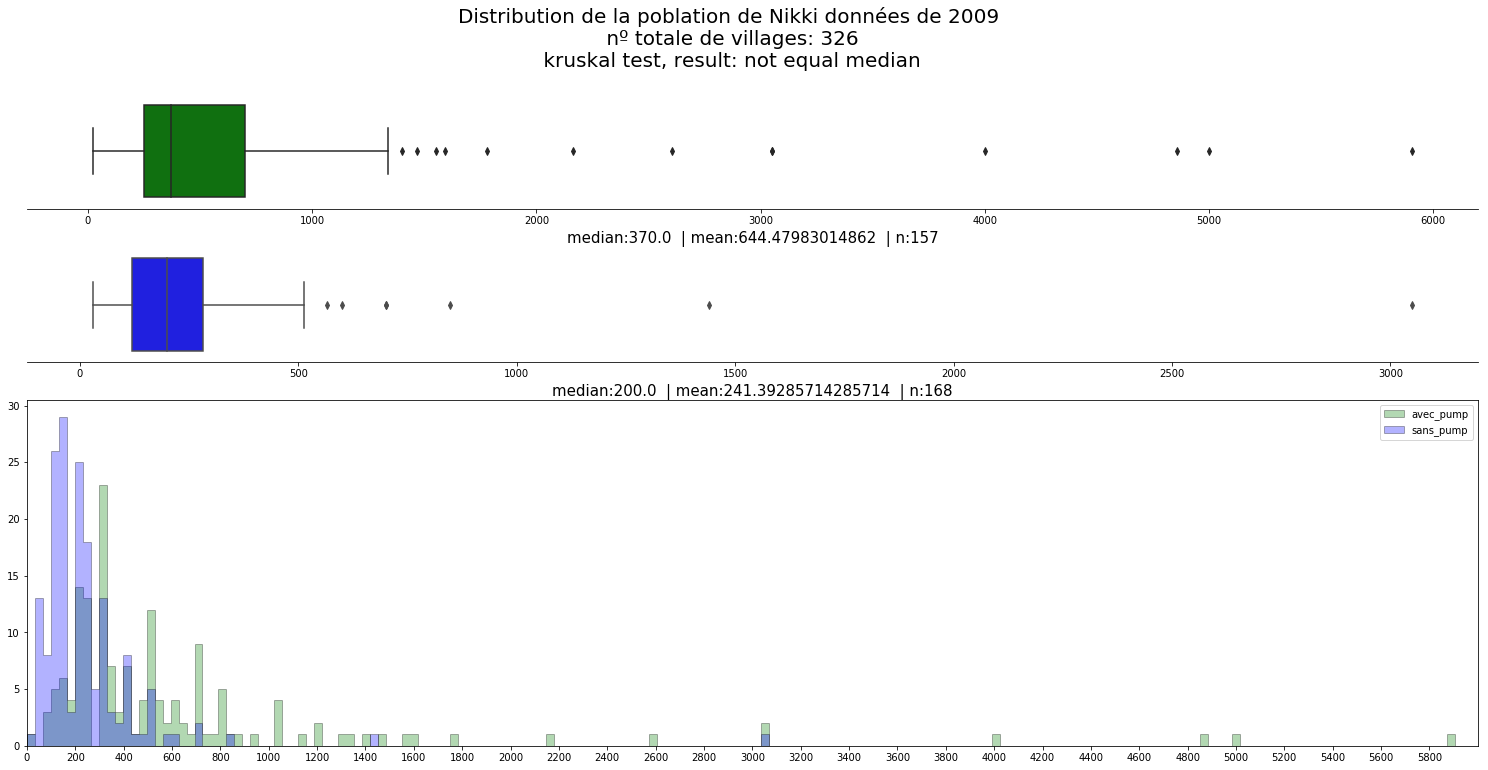

In [122]:
f, (ax_box1,axbox2,ax_hist) = plt.subplots(3, gridspec_kw={'height_ratios': [2,2, 6]})

n=3
bins=np.arange(0,6000+int(100/n),int(100/n))
subplots=[ax_box1,axbox2]

kwargs = dict(histtype='stepfilled', alpha=0.3, bins=bins,edgecolor='black')
for label,boolean,subplot,color in zip(['avec_pump','sans_pump'],[True,False],subplots,['green','blue']):

  data=df_pop[df_pop['haspump']==boolean]['Pop'].dropna()

  ax_hist.hist(data,label=label,color=color,**kwargs)

  sns.boxplot(data, ax=subplot,color=color)
  sns.despine(ax=subplot, left=True)
  subplot.set(yticks=[])
  subplot.set_xlabel('median:'+str(data.quantile(0.5))+'  | '+
                       'mean:'+str(data.mean())+'  | '+
                       'n:'+str(len(data))+'\n\n',fontsize=15)

test = stats.kruskal(df_pop[df_pop['haspump']==True]['Pop'].dropna(),
                     df_pop[df_pop['haspump']==False]['Pop'].dropna())
if test[1]>0.05:
  test='equal median'
else:
  test='not equal median'

f.suptitle('Distribution de la poblation de Nikki données de 2009'+
           '\n nº totale de villages: '+str(len(df_pop))+
          '\n kruskal test, result: '+str(test),
          fontsize=20)

ax_hist.set_xticks(np.arange(0,6000,200))
ax_hist.set_xlim([0,6000])
ax_hist.legend()


plt.show()